In [21]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False
print('XGBoost available:', XGB_AVAILABLE)

XGBoost available: True


In [22]:
CSV_PATH_CANDIDATES = [
    'flight_price_dataset.csv',
    '/mnt/data/flight_price_dataset.csv'
]
csv_path = None
for p in CSV_PATH_CANDIDATES:
    if os.path.exists(p):
        csv_path = p
        break
if csv_path is None:
    raise FileNotFoundError("Could not find 'flight_price_dataset.csv'. Place it next to the notebook.")
data = pd.read_csv(csv_path)
print('Loaded:', csv_path)
data.head()

Loaded: flight_price_dataset.csv


,Airline,Source,Destination,Date_of_Journey,Departure_Time,Arrival_Time,Duration_hours,Total_Stops,Class,Price
0,Air India,Kolkata,Mumbai,01/09/2025,Afternoon,Night,8.8,0,Economy,7557
1,GoAir,Bangalore,Bangalore,02/09/2025,Night,Night,11.6,1,Economy,9880
2,Emirates,Kolkata,Bangalore,03/09/2025,Afternoon,Night,11.1,0,Business,17421
3,GoAir,Kolkata,Delhi,04/09/2025,Night,Evening,12.0,2,Economy,10760
4,Vistara,Hyderabad,Hyderabad,05/09/2025,Evening,Night,5.9,2,Business,12597


In [7]:
print('Shape:', data.shape)

Shape: (50, 10)


In [8]:
print('\nColumns:', list(data.columns))


Columns: ['Airline', 'Source', 'Destination', 'Date_of_Journey', 'Departure_Time', 'Arrival_Time', 'Duration_hours', 'Total_Stops', 'Class', 'Price']


In [9]:
print('\nMissing values:\n', data.isnull().sum())


Missing values:
 Airline            0
Source             0
Destination        0
Date_of_Journey    0
Departure_Time     0
Arrival_Time       0
Duration_hours     0
Total_Stops        0
Class              0
Price              0
dtype: int64


In [10]:
data.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Airline,50,7,Emirates,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Source,50,6,Hyderabad,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Destination,50,6,Delhi,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date_of_Journey,50,50,01/09/2025,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Departure_Time,50,4,Night,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arrival_Time,50,4,Evening,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Duration_hours,50.0,NaN,NaN,NaN,6.872,3.410131,1.1,3.575,6.95,9.375,12.0
Total_Stops,50.0,NaN,NaN,NaN,1.1,0.839096,0.0,0.0,1.0,2.0,2.0
Class,50,2,Business,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,50.0,NaN,NaN,NaN,12378.54,3874.49172,3355.0,10048.75,12574.5,15259.0,18486.0


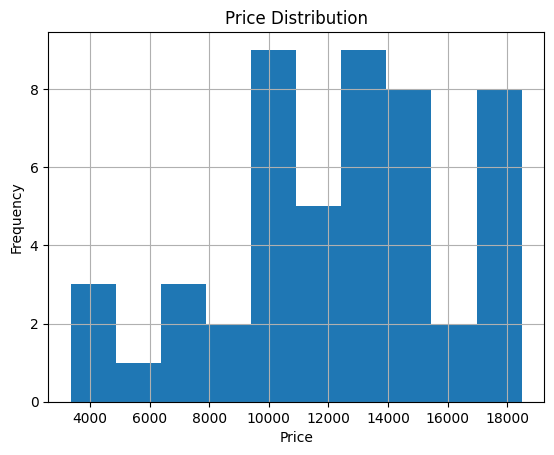

In [11]:
plt.figure()
data['Price'].hist(bins=10)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

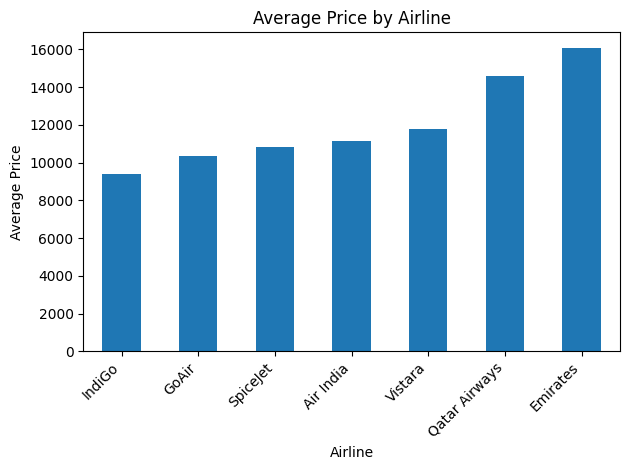

,AvgPrice
Airline,
IndiGo,9398.857143
GoAir,10341.750000
SpiceJet,10829.000000
Air India,11116.000000
Vistara,11760.000000
Qatar Airways,14568.571429
Emirates,16092.727273


In [12]:
avg_price_airline = data.groupby('Airline')['Price'].mean().sort_values()
plt.figure()
avg_price_airline.plot(kind='bar')
plt.title('Average Price by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

avg_price_airline.to_frame('AvgPrice')

In [13]:
df = data.copy()
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], dayfirst=True, errors='coerce')
df['Journey_Day'] = df['Date_of_Journey'].dt.day
df['Journey_Month'] = df['Date_of_Journey'].dt.month
df.drop(columns=['Date_of_Journey'], inplace=True)
df.head()

,Airline,Source,Destination,Departure_Time,Arrival_Time,Duration_hours,Total_Stops,Class,Price,Journey_Day,Journey_Month
0,Air India,Kolkata,Mumbai,Afternoon,Night,8.8,0,Economy,7557,1,9
1,GoAir,Bangalore,Bangalore,Night,Night,11.6,1,Economy,9880,2,9
2,Emirates,Kolkata,Bangalore,Afternoon,Night,11.1,0,Business,17421,3,9
3,GoAir,Kolkata,Delhi,Night,Evening,12.0,2,Economy,10760,4,9
4,Vistara,Hyderabad,Hyderabad,Evening,Night,5.9,2,Business,12597,5,9


In [14]:
TARGET = 'Price'
y = df[TARGET]
feature_cols = [c for c in df.columns if c != TARGET]
X = df[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((40, 10), (10, 10))

In [15]:
categorical_cols = ['Airline', 'Source', 'Destination', 'Departure_Time', 'Arrival_Time', 'Class']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)
print('Categorical:', categorical_cols)
print('Numeric:', numeric_cols)

Categorical: ['Airline', 'Source', 'Destination', 'Departure_Time', 'Arrival_Time', 'Class']
Numeric: ['Duration_hours', 'Total_Stops', 'Journey_Day', 'Journey_Month']


In [23]:

def evaluate(model_name, model, X_train, y_train, X_test, y_test):
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"\n=== {model_name} ===")
    print("MAE :", mae)
    print("RMSE:", rmse)
    print("R²  :", r2)
    return {'model': model_name, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'pipeline': pipe}
results = []
results.append(evaluate('LinearRegression', LinearRegression(), X_train, y_train, X_test, y_test))
rf = RandomForestRegressor(n_estimators=300, random_state=42)
results.append(evaluate('RandomForest', rf, X_train, y_train, X_test, y_test))
if XGB_AVAILABLE:
    xgb = XGBRegressor(n_estimators=400, max_depth=6, learning_rate=0.07, subsample=0.9, colsample_bytree=0.9, random_state=42)
    results.append(evaluate('XGBoost', xgb, X_train, y_train, X_test, y_test))
else:
    print("\nXGBoost not installed; skipping XGB model.")


=== LinearRegression ===
MAE : 434.157169250749
RMSE: 577.7707569131911
R²  : 0.9816160089418396

=== RandomForest ===
MAE : 1632.1626666666666
RMSE: 1878.4417855327738
R²  : 0.8056770175488585

=== XGBoost ===
MAE : 1408.790771484375
RMSE: 1602.6882104763858
R²  : 0.858542263507843


In [17]:
res_df = pd.DataFrame([{'Model': r['model'], 'MAE': r['MAE'], 'RMSE': r['RMSE'], 'R2': r['R2']} for r in results])
res_df.sort_values('RMSE')

,Model,MAE,RMSE,R2
0,LinearRegression,434.157169,577.770757,0.981616
2,XGBoost,1408.790771,1602.688210,0.858542
1,RandomForest,1632.162667,1878.441786,0.805677


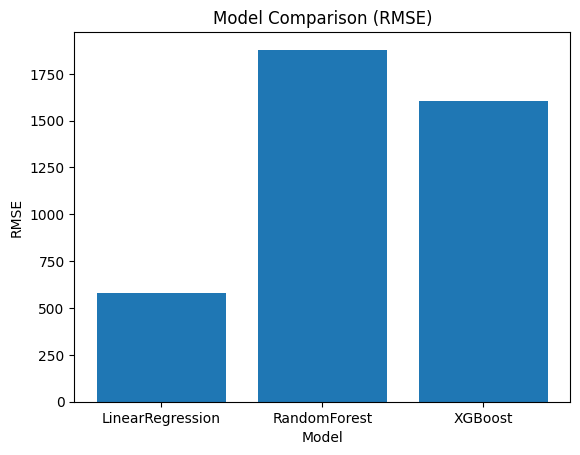

In [18]:
plt.figure()
plt.bar(res_df['Model'], res_df['RMSE'])
plt.title('Model Comparison (RMSE)')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()

In [19]:
best = min(results, key=lambda r: r['RMSE'])
best_name = best['model']
best_pipe = best['pipeline']
print('Best model:', best_name)
preds = best_pipe.predict(X_test)
sample = pd.DataFrame({'Actual': y_test.values, 'Predicted': preds})
sample.head(10)

Best model: LinearRegression


,Actual,Predicted
0,3355,2894.787867
1,17141,16989.559453
2,6838,6608.521766
3,13739,12766.176253
4,12552,12527.391921
5,10634,9768.568329
6,18486,18753.696285
7,12352,13460.531513
8,9874,9904.220777
9,9874,10105.128705
